In [ ]:
!pip install matplotlib tensorflow-probability

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [ ]:
import tensorflow as tf
from datetime import datetime as dt
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
class MinibatchDiscriminator(tf.keras.layers.Layer):
    def __init__(self, b, c):
        super(MinibatchDiscriminator, self).__init__()
        self.b = b
        self.c = c

    def build(self, input_shape):
        self.T = self.add_weight(
            shape=(input_shape[-1], self.b, self.c),
            initializer=tf.keras.initializers.Zeros(),
            trainable=True,
        )
    
    @tf.function
    def call(self, inputs):
        M = tf.tensordot(inputs, self.T, axes=[[1],[0]])
        diff = tf.expand_dims(M,0) - tf.expand_dims(M,1)
        c = tf.math.exp(-tf.norm(diff, ord=1, axis=3))
        o = tf.reduce_sum(c, axis=1)
        return tf.concat([inputs, o], 1)

     

In [ ]:
a = tf.cast(tf.constant([[1,1],[2,2],[3,3],[4,4],[5,5]]), 'float')
ll = MinibatchDiscriminator(10,11)
out = ll(a)
print(out.shape)

2022-02-17 15:21:10.931333: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-17 15:21:10.944039: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-17 15:21:10.944978: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-17 15:21:10.947195: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-17 15:21:10.948090: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read f

(5, 12)


In [ ]:
class AAE:
    def __init__(self, input_shape, latent_dim, leaky_alpha, filters, kernel_size, strides, dense_units, discriminator_units, keep_prob, minidc_dims, base_lr, max_lr, step_size):
        super(AAE, self).__init__()
        self.stride_reduction = 1
        for i, stride in enumerate(strides):
            self.stride_reduction = self.stride_reduction * stride
        self.latent_dim = latent_dim
        self.ae_optimizer = tf.keras.optimizers.Adam(learning_rate=base_lr)
        self.gen_optimizer = tf.keras.optimizers.Adam(learning_rate=base_lr)
        self.dc_optimizer = tf.keras.optimizers.Adam(learning_rate=base_lr)
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        self.ae_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)
        self.dc_accuracy = tf.keras.metrics.BinaryAccuracy()
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        

        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=input_shape),
            tf.keras.layers.Conv2D(filters=filters[0], kernel_size=kernel_size[0], strides=strides[0], padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(leaky_alpha),
            tf.keras.layers.Conv2D(filters=filters[1], kernel_size=kernel_size[1], strides=strides[1], padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(leaky_alpha),
            tf.keras.layers.Conv2D(filters=filters[2], kernel_size=kernel_size[2], strides=strides[2], padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(leaky_alpha),
            tf.keras.layers.Conv2D(filters=filters[3], kernel_size=kernel_size[3], strides=strides[3], padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(leaky_alpha),
            #tf.keras.layers.Conv2D(filters=filters[4], kernel_size=kernel_size[4], strides=strides[4], padding='same'),
            #tf.keras.layers.BatchNormalization(),
            #tf.keras.layers.LeakyReLU(leaky_alpha),
            tf.keras.layers.Flatten(),
            #tf.keras.layers.Dense(dense_units[0], activation='relu'),
            #tf.keras.layers.BatchNormalization(),
            #tf.keras.layers.Dense(dense_units[1], activation='relu'),
            #tf.keras.layers.BatchNormalization(),
            #tf.keras.layers.Dense(dense_units[2], activation='tanh'),
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ])

        self.decoder = tf.keras.Sequential([
            #tf.keras.layers.InputLayer(input_shape=latent_dim),
            #tf.keras.layers.Dense(dense_units[2], activation='tanh'),
            #tf.keras.layers.Dense(dense_units[1], activation='relu'),
            #tf.keras.layers.BatchNormalization(),
            #tf.keras.layers.Dense(dense_units[0], activation='relu'),
            #tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(int(input_shape[0]*input_shape[1]*filters[3]/self.stride_reduction**2), activation='relu'),
            tf.keras.layers.Reshape((int(input_shape[0]/self.stride_reduction), int(input_shape[1]/self.stride_reduction), filters[3])),
            #tf.keras.layers.Conv2DTranspose(filters=filters[4], kernel_size=kernel_size[4], strides=strides[4], padding='same'),
            #tf.keras.layers.BatchNormalization(),
            #tf.keras.layers.LeakyReLU(leaky_alpha),
            tf.keras.layers.Conv2DTranspose(filters=filters[3], kernel_size=kernel_size[3], strides=strides[3], padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(leaky_alpha),
            tf.keras.layers.Conv2DTranspose(filters=filters[2], kernel_size=kernel_size[2], strides=strides[2], padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(leaky_alpha),
            tf.keras.layers.Conv2DTranspose(filters=filters[1], kernel_size=kernel_size[1], strides=strides[1], padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(leaky_alpha),
            tf.keras.layers.Conv2DTranspose(filters=filters[0], kernel_size=kernel_size[0], strides=strides[0], padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(leaky_alpha),
            tf.keras.layers.Conv2DTranspose(filters=input_shape[2], kernel_size=kernel_size[0], strides=1, padding='same'),
        ])

        self.discriminator = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(discriminator_units[0], activation='relu'),
            #tf.keras.layers.BatchNormalization(),
            #tf.keras.layers.Dropout(keep_prob),
            #MinibatchDiscriminator(minidc_dims[0,0], minidc_dims[0,1]),
            tf.keras.layers.Dense(discriminator_units[1], activation='relu'),
            #tf.keras.layers.BatchNormalization(),
            #tf.keras.layers.Dropout(keep_prob),
            #MinibatchDiscriminator(minidc_dims[1,0], minidc_dims[1,1]),
            #tf.keras.layers.Dense(discriminator_units[2], activation='relu'),
            #tf.keras.layers.Dropout(keep_prob),
            tf.keras.layers.Dense(1),
        ])
    
    def sample(self, n_samples, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(n_samples, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    @tf.function
    def encode(self, x, training=False):
        mean, log_var = tf.split(self.encoder(x, training=training), num_or_size_splits=2, axis=1)
        return mean, log_var

    @tf.function
    def reparametrize(self, mean, log_var):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(log_var * .5) + mean
    
    @tf.function
    def encode_and_reparametrize(self, x, training=False):
        mean, log_var = tf.split(self.encoder(x, training=training), num_or_size_splits=2, axis=1)
        return self.reparametrize(mean, log_var)

    @tf.function
    def decode(self, z, apply_sigmoid=False, training=False):
        logits = self.decoder(z, training=training)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits
    
    @tf.function
    def autoencoder_loss(self, X, training=False):
        # Generate latent space vector by encoding X
        mean_generated, log_var_generated = self.encode(X, training=training)
        z_generated = self.reparametrize(mean_generated, log_var_generated)
        # Decode
        X_generated = self.decode(z_generated, apply_sigmoid=True, training=training)
        # Autoencoder loss
        ae_loss = tf.reduce_mean(tf.math.squared_difference(X_generated, X))
        #ae_loss = self.ae_cross_entropy(y_true=X, y_pred=X_generated)
        return ae_loss
    
    @tf.function
    def generator_loss(self, fake_output):
        return self.cross_entropy(tf.ones_like(fake_output), fake_output)

    @tf.function
    def discriminator_loss(self, real_output, fake_output):
        real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

    @tf.function
    def train_step(self, batch_x):
        # Autoencoder
        with tf.GradientTape() as ae_tape:
            # Autoencoder loss
            ae_loss = self.autoencoder_loss(batch_x, training=True)
    
        ae_grads = ae_tape.gradient(ae_loss, self.encoder.trainable_variables + self.decoder.trainable_variables)
        self.ae_optimizer.apply_gradients(zip(ae_grads, self.encoder.trainable_variables + self.decoder.trainable_variables))

        generated_noise = tf.random.normal([batch_x.shape[0], self.latent_dim], mean=0.0, stddev=1.0)
        # Discriminator
        with tf.GradientTape() as dc_tape:
            encoder_output = self.encode_and_reparametrize(batch_x, training=False)
            dc_fake = self.discriminator(encoder_output, training=True)
            dc_real = self.discriminator(generated_noise, training=True)
            # Discriminator Loss
            dc_loss = self.discriminator_loss(dc_real, dc_fake)
            # Discriminator Acc
            dc_acc = self.dc_accuracy(tf.concat([tf.ones_like(dc_real), tf.zeros_like(dc_fake)], axis=0),
                        tf.concat([dc_real, dc_fake], axis=0))

        dc_grads = dc_tape.gradient(dc_loss, self.discriminator.trainable_variables)
        self.dc_optimizer.apply_gradients(zip(dc_grads, self.discriminator.trainable_variables))

        # Generator (Encoder)
        with tf.GradientTape() as gen_tape:
            encoder_output = self.encode_and_reparametrize(batch_x, training=True)
            dc_fake = self.discriminator(encoder_output, training=False)
            # Generator loss
            gen_loss = self.generator_loss(dc_fake)

        gen_grads = gen_tape.gradient(gen_loss, self.encoder.trainable_variables)
        self.gen_optimizer.apply_gradients(zip(gen_grads, self.encoder.trainable_variables))

        return ae_loss, dc_loss, dc_acc, gen_loss
    
    def fit(self, train_dataset, epochs):
        self.encoder.compile()
        self.decoder.compile()
        self.discriminator.compile()
        ae_loss_history = []
        dc_loss_history = []
        gen_loss_history = []
        global_step = 0
        ae_loss = 0
        dc_loss = 0
        dc_acc = 0
        gen_loss = 0
        for epoch in range(epochs):
            if epoch in [40, 80, 120, 160, 200]:
                self.base_lr = self.base_lr / 2
                self.max_lr = self.max_lr / 2
                self.step_size = self.step_size / 2
            epoch_start = dt.now()
            for train_x in train_dataset:
            #    global_step = global_step + 1
            #    cycle = np.floor(1 + global_step / (2 * self.step_size))
            #    x_lr = np.abs(global_step / self.step_size - 2 * cycle + 1)
            #    clr = self.base_lr + (self.max_lr - self.base_lr) * max(0, 1 - x_lr)
                self.ae_optimizer.learning_rate = base_lr
                self.dc_optimizer.learning_rate = base_lr
                self.gen_optimizer.learning_rate = base_lr
                ae_loss, dc_loss, dc_acc, gen_loss = self.train_step(train_x)
                ae_loss_history.append(ae_loss)
                dc_loss_history.append(dc_loss)
                gen_loss_history.append(gen_loss)
        
            epoch_end = dt.now()
            print("Epoch: {}, time elapsed: {}, AE loss: {}, Discriminator loss: {}, Discriminator accuracy: {}, Generator loss: {}".format(epoch + 1, epoch_end - epoch_start, ae_loss, dc_loss, dc_acc, gen_loss))
        
        return ae_loss_history, dc_loss_history, gen_loss_history


In [ ]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

def preprocess_images(images):
    images = images.reshape((images.shape[0], 32, 32, 3)).astype('float32') / 255.
    return images

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

length = train_images.shape[1]
width = train_images.shape[2]
channels = train_images.shape[3]

train_size = train_images.shape[0]
test_size = test_images.shape[0]
batch_size = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(train_size).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(test_size).batch(batch_size)

In [ ]:
minidc_dims=np.array([[30,30],[30,30]])

base_lr = 0.001
max_lr = 0.0025
step_size = 2 * np.ceil(train_images.shape[0] / batch_size)
epochs = 350

latent_dim = 128
alpha_leaky = 0.2
filters = [48,96,192,384]
kernel_size = [4,4,3,3]
strides = [2,2,2,2]
dense_units = [500,300]
discriminator_units = [200, 100]
keep_prob = 0.5

steps_per_epoch = train_images.shape[0] / batch_size

aae = AAE((length, width, channels), latent_dim, alpha_leaky, filters, kernel_size, strides, dense_units, discriminator_units, keep_prob, minidc_dims, base_lr, max_lr, step_size)
ae_loss_history, dc_loss_history, gen_loss_history = aae.fit(train_dataset, epochs=epochs)

2022-02-17 15:21:21.428341: I tensorflow/stream_executor/cuda/cuda_dnn.cc:381] Loaded cuDNN version 8204


Epoch: 1, time elapsed: 0:00:41.157090, AE loss: 0.02664216421544552, Discriminator loss: 0.29701706767082214, Discriminator accuracy: 0.8011699914932251, Generator loss: 27.06268882751465


Epoch: 2, time elapsed: 0:00:41.583752, AE loss: 0.01913970336318016, Discriminator loss: 0.09480344504117966, Discriminator accuracy: 0.8837699890136719, Generator loss: 34.833370208740234


Epoch: 3, time elapsed: 0:00:33.297356, AE loss: 0.016377640888094902, Discriminator loss: 0.029751652851700783, Discriminator accuracy: 0.9139900207519531, Generator loss: 62.44892120361328


Epoch: 4, time elapsed: 0:00:33.327921, AE loss: 0.013426972553133965, Discriminator loss: 0.038262128829956055, Discriminator accuracy: 0.9329624772071838, Generator loss: 33.095760345458984


Epoch: 5, time elapsed: 0:00:33.360397, AE loss: 0.012518097646534443, Discriminator loss: 0.0264879260212183, Discriminator accuracy: 0.9448620080947876, Generator loss: 31.74148178100586


Epoch: 6, time elapsed: 0:00:33.342695, AE loss: 0.011432298459112644, Discriminator loss: 0.02859097719192505, Discriminator accuracy: 0.9533816576004028, Generator loss: 30.338180541992188


Epoch: 7, time elapsed: 0:00:33.339778, AE loss: 0.009923598729074001, Discriminator loss: 0.009038862772285938, Discriminator accuracy: 0.9597671627998352, Generator loss: 27.47073745727539


Epoch: 8, time elapsed: 0:00:33.370933, AE loss: 0.008799644187092781, Discriminator loss: 0.01386618334800005, Discriminator accuracy: 0.9646012783050537, Generator loss: 33.0541877746582


Epoch: 9, time elapsed: 0:00:41.550287, AE loss: 0.008981158956885338, Discriminator loss: 0.01796054095029831, Discriminator accuracy: 0.9684155583381653, Generator loss: 27.065975189208984


Epoch: 10, time elapsed: 0:00:33.354107, AE loss: 0.0092045022174716, Discriminator loss: 0.010904515162110329, Discriminator accuracy: 0.9714509844779968, Generator loss: 22.601055145263672


Epoch: 11, time elapsed: 0:00:33.379088, AE loss: 0.008684848435223103, Discriminator loss: 0.012339679524302483, Discriminator accuracy: 0.97386634349823, Generator loss: 20.631567001342773


Epoch: 12, time elapsed: 0:00:33.327069, AE loss: 0.008721867576241493, Discriminator loss: 0.039614155888557434, Discriminator accuracy: 0.975754976272583, Generator loss: 25.946788787841797


Epoch: 13, time elapsed: 0:00:33.344696, AE loss: 0.007806290406733751, Discriminator loss: 0.024105072021484375, Discriminator accuracy: 0.9772184491157532, Generator loss: 22.275039672851562


Epoch: 14, time elapsed: 0:00:33.428036, AE loss: 0.00821706186980009, Discriminator loss: 0.19529905915260315, Discriminator accuracy: 0.9782714247703552, Generator loss: 17.636030197143555


Epoch: 15, time elapsed: 0:00:33.413247, AE loss: 0.007843381725251675, Discriminator loss: 0.1332961916923523, Discriminator accuracy: 0.9789100289344788, Generator loss: 21.534589767456055


Epoch: 16, time elapsed: 0:00:33.333338, AE loss: 0.00727827800437808, Discriminator loss: 0.05491789057850838, Discriminator accuracy: 0.9792081117630005, Generator loss: 25.316404342651367


Epoch: 17, time elapsed: 0:00:33.360896, AE loss: 0.008610699325799942, Discriminator loss: 0.30361974239349365, Discriminator accuracy: 0.9792370796203613, Generator loss: 18.107013702392578


Epoch: 18, time elapsed: 0:00:33.356239, AE loss: 0.007324861828237772, Discriminator loss: 0.06635596603155136, Discriminator accuracy: 0.9791789054870605, Generator loss: 19.972164154052734


Epoch: 19, time elapsed: 0:00:41.598012, AE loss: 0.0075681391172111034, Discriminator loss: 0.08080457150936127, Discriminator accuracy: 0.9784278869628906, Generator loss: 21.763290405273438


Epoch: 20, time elapsed: 0:00:33.357744, AE loss: 0.007300839759409428, Discriminator loss: 0.3324659466743469, Discriminator accuracy: 0.9777014851570129, Generator loss: 14.975544929504395


Epoch: 21, time elapsed: 0:00:33.338817, AE loss: 0.008058139123022556, Discriminator loss: 0.1776179075241089, Discriminator accuracy: 0.9759514331817627, Generator loss: 11.082342147827148


Epoch: 22, time elapsed: 0:00:33.343524, AE loss: 0.006706364452838898, Discriminator loss: 0.5720152854919434, Discriminator accuracy: 0.9731195569038391, Generator loss: 7.6014227867126465


Epoch: 23, time elapsed: 0:00:41.584167, AE loss: 0.007464332040399313, Discriminator loss: 0.44435545802116394, Discriminator accuracy: 0.9692873954772949, Generator loss: 5.614343166351318


Epoch: 24, time elapsed: 0:00:33.360611, AE loss: 0.0082171019166708, Discriminator loss: 0.6268396377563477, Discriminator accuracy: 0.965227484703064, Generator loss: 4.617465972900391


Epoch: 25, time elapsed: 0:00:33.410299, AE loss: 0.007570927496999502, Discriminator loss: 0.5817551612854004, Discriminator accuracy: 0.9609308242797852, Generator loss: 4.235991477966309


Epoch: 26, time elapsed: 0:00:33.406710, AE loss: 0.007376912049949169, Discriminator loss: 0.9680008292198181, Discriminator accuracy: 0.9550272822380066, Generator loss: 3.227644443511963


Epoch: 27, time elapsed: 0:00:33.374353, AE loss: 0.006150102708488703, Discriminator loss: 0.9745595455169678, Discriminator accuracy: 0.9479777812957764, Generator loss: 2.900749444961548


Epoch: 28, time elapsed: 0:00:41.602469, AE loss: 0.008079257793724537, Discriminator loss: 1.05380117893219, Discriminator accuracy: 0.9418392777442932, Generator loss: 2.477930784225464


Epoch: 29, time elapsed: 0:00:33.305910, AE loss: 0.006748666521161795, Discriminator loss: 1.1436882019042969, Discriminator accuracy: 0.9355300068855286, Generator loss: 1.7325128316879272


Epoch: 30, time elapsed: 0:00:33.287840, AE loss: 0.006715775933116674, Discriminator loss: 1.3136684894561768, Discriminator accuracy: 0.9280016422271729, Generator loss: 1.902235746383667


Epoch: 31, time elapsed: 0:00:33.333039, AE loss: 0.006153658963739872, Discriminator loss: 1.1141406297683716, Discriminator accuracy: 0.9199122786521912, Generator loss: 1.513030767440796


Epoch: 32, time elapsed: 0:00:33.381886, AE loss: 0.006824065465480089, Discriminator loss: 1.0926618576049805, Discriminator accuracy: 0.9129577875137329, Generator loss: 2.3042972087860107


Epoch: 33, time elapsed: 0:00:33.355784, AE loss: 0.006511715240776539, Discriminator loss: 1.3779199123382568, Discriminator accuracy: 0.9055399894714355, Generator loss: 1.17985999584198


Epoch: 34, time elapsed: 0:00:33.356350, AE loss: 0.007521524094045162, Discriminator loss: 0.9283303618431091, Discriminator accuracy: 0.8974864482879639, Generator loss: 1.533722162246704


Epoch: 35, time elapsed: 0:00:33.341735, AE loss: 0.006116450764238834, Discriminator loss: 1.1789064407348633, Discriminator accuracy: 0.8889994025230408, Generator loss: 1.1619420051574707


Epoch: 36, time elapsed: 0:00:33.367144, AE loss: 0.007229643873870373, Discriminator loss: 1.4082841873168945, Discriminator accuracy: 0.8811430335044861, Generator loss: 0.8266664743423462


Epoch: 37, time elapsed: 0:00:33.352342, AE loss: 0.006149988155812025, Discriminator loss: 1.1770278215408325, Discriminator accuracy: 0.873494029045105, Generator loss: 1.2714563608169556


Epoch: 39, time elapsed: 0:00:41.637460, AE loss: 0.0064736162312328815, Discriminator loss: 1.3530464172363281, Discriminator accuracy: 0.859492301940918, Generator loss: 1.0354180335998535


Epoch: 40, time elapsed: 0:00:33.843230, AE loss: 0.006106184795498848, Discriminator loss: 1.2540041208267212, Discriminator accuracy: 0.8527027368545532, Generator loss: 1.370636224746704


Epoch: 41, time elapsed: 0:00:33.621583, AE loss: 0.006273842882364988, Discriminator loss: 1.2076529264450073, Discriminator accuracy: 0.8462168574333191, Generator loss: 1.2198082208633423


Epoch: 42, time elapsed: 0:00:33.645682, AE loss: 0.0077258446253836155, Discriminator loss: 1.3862667083740234, Discriminator accuracy: 0.839932382106781, Generator loss: 0.9402362108230591


Epoch: 43, time elapsed: 0:00:33.434331, AE loss: 0.006899893283843994, Discriminator loss: 1.3956403732299805, Discriminator accuracy: 0.834099531173706, Generator loss: 1.021026372909546


Epoch: 44, time elapsed: 0:00:33.420132, AE loss: 0.007811434101313353, Discriminator loss: 1.302108645439148, Discriminator accuracy: 0.8281136155128479, Generator loss: 1.174440622329712


Epoch: 45, time elapsed: 0:00:33.439595, AE loss: 0.006653276272118092, Discriminator loss: 1.2424262762069702, Discriminator accuracy: 0.8221179842948914, Generator loss: 1.0258023738861084


Epoch: 46, time elapsed: 0:00:33.392766, AE loss: 0.007297149393707514, Discriminator loss: 1.2717649936676025, Discriminator accuracy: 0.8159993290901184, Generator loss: 1.1432714462280273


Epoch: 47, time elapsed: 0:00:33.386918, AE loss: 0.007726623676717281, Discriminator loss: 1.0336577892303467, Discriminator accuracy: 0.8108912706375122, Generator loss: 1.3364700078964233


Epoch: 48, time elapsed: 0:00:33.369874, AE loss: 0.00791997741907835, Discriminator loss: 1.2813637256622314, Discriminator accuracy: 0.8049575090408325, Generator loss: 1.0627254247665405


Epoch: 49, time elapsed: 0:00:33.384900, AE loss: 0.007873741909861565, Discriminator loss: 1.263771414756775, Discriminator accuracy: 0.7999069094657898, Generator loss: 1.152806282043457


Epoch: 50, time elapsed: 0:00:33.322244, AE loss: 0.009514006786048412, Discriminator loss: 1.176315188407898, Discriminator accuracy: 0.7949740290641785, Generator loss: 1.9730911254882812


Epoch: 51, time elapsed: 0:00:33.361624, AE loss: 0.012464716099202633, Discriminator loss: 0.08252505958080292, Discriminator accuracy: 0.7970201969146729, Generator loss: 10.49460506439209


Epoch: 52, time elapsed: 0:00:33.398655, AE loss: 0.014820665121078491, Discriminator loss: 0.052102476358413696, Discriminator accuracy: 0.8005698323249817, Generator loss: 16.5163516998291


Epoch: 53, time elapsed: 0:00:33.365741, AE loss: 0.014106527902185917, Discriminator loss: 0.22870782017707825, Discriminator accuracy: 0.803292989730835, Generator loss: 12.638702392578125


Epoch: 54, time elapsed: 0:00:33.396080, AE loss: 0.012119418010115623, Discriminator loss: 0.49928244948387146, Discriminator accuracy: 0.8047085404396057, Generator loss: 6.735813140869141


Epoch: 55, time elapsed: 0:00:33.401668, AE loss: 0.011497178114950657, Discriminator loss: 0.9357478618621826, Discriminator accuracy: 0.8046265244483948, Generator loss: 5.844803810119629


Epoch: 56, time elapsed: 0:00:41.546751, AE loss: 0.00994991697371006, Discriminator loss: 0.7619900703430176, Discriminator accuracy: 0.8033925294876099, Generator loss: 3.2122979164123535


Epoch: 57, time elapsed: 0:00:33.434614, AE loss: 0.008846589364111423, Discriminator loss: 1.1217033863067627, Discriminator accuracy: 0.8020289540290833, Generator loss: 2.1068825721740723


Epoch: 58, time elapsed: 0:00:33.407622, AE loss: 0.008455839939415455, Discriminator loss: 1.0215656757354736, Discriminator accuracy: 0.8005955219268799, Generator loss: 2.0104780197143555


Epoch: 59, time elapsed: 0:00:33.597370, AE loss: 0.008367286063730717, Discriminator loss: 0.9807391166687012, Discriminator accuracy: 0.7983199954032898, Generator loss: 2.217036724090576


Epoch: 60, time elapsed: 0:00:33.771841, AE loss: 0.00865225400775671, Discriminator loss: 1.1474988460540771, Discriminator accuracy: 0.7962920069694519, Generator loss: 2.0724384784698486


Epoch: 61, time elapsed: 0:00:41.603543, AE loss: 0.00787658616900444, Discriminator loss: 1.2320094108581543, Discriminator accuracy: 0.7940616607666016, Generator loss: 2.163290500640869


Epoch: 62, time elapsed: 0:00:33.539248, AE loss: 0.007277983240783215, Discriminator loss: 1.3566043376922607, Discriminator accuracy: 0.7920082211494446, Generator loss: 1.0548863410949707


Epoch: 63, time elapsed: 0:00:41.590837, AE loss: 0.006853259634226561, Discriminator loss: 1.2211509943008423, Discriminator accuracy: 0.7898522019386292, Generator loss: 1.846649408340454


Epoch: 64, time elapsed: 0:00:33.481690, AE loss: 0.00839985627681017, Discriminator loss: 1.2310148477554321, Discriminator accuracy: 0.7876574993133545, Generator loss: 1.3546059131622314


Epoch: 65, time elapsed: 0:00:41.624833, AE loss: 0.008071327582001686, Discriminator loss: 1.195786476135254, Discriminator accuracy: 0.7850416898727417, Generator loss: 1.2412779331207275


Epoch: 66, time elapsed: 0:00:33.411072, AE loss: 0.008350426331162453, Discriminator loss: 1.1708102226257324, Discriminator accuracy: 0.7824622988700867, Generator loss: 1.7041761875152588


Epoch: 67, time elapsed: 0:00:33.458488, AE loss: 0.007667766883969307, Discriminator loss: 1.2126398086547852, Discriminator accuracy: 0.7799325585365295, Generator loss: 1.3227230310440063


Epoch: 68, time elapsed: 0:00:33.527932, AE loss: 0.0073953429237008095, Discriminator loss: 1.4071964025497437, Discriminator accuracy: 0.7770528197288513, Generator loss: 0.9266330599784851


Epoch: 69, time elapsed: 0:00:41.594633, AE loss: 0.00715936254709959, Discriminator loss: 1.3142750263214111, Discriminator accuracy: 0.7744531631469727, Generator loss: 1.337578535079956


Epoch: 70, time elapsed: 0:00:33.525981, AE loss: 0.007876086980104446, Discriminator loss: 1.4756014347076416, Discriminator accuracy: 0.7716195583343506, Generator loss: 1.0724846124649048


Epoch: 71, time elapsed: 0:00:33.435854, AE loss: 0.00839868001639843, Discriminator loss: 1.092692255973816, Discriminator accuracy: 0.7688494324684143, Generator loss: 1.7637293338775635


Epoch: 72, time elapsed: 0:00:33.432745, AE loss: 0.007143822964280844, Discriminator loss: 1.3152563571929932, Discriminator accuracy: 0.766004741191864, Generator loss: 1.0007188320159912


Epoch: 73, time elapsed: 0:00:33.462684, AE loss: 0.008385402150452137, Discriminator loss: 1.1606090068817139, Discriminator accuracy: 0.762905478477478, Generator loss: 1.4155848026275635


Epoch: 74, time elapsed: 0:00:33.470547, AE loss: 0.00808669812977314, Discriminator loss: 1.3391222953796387, Discriminator accuracy: 0.7602590322494507, Generator loss: 0.9621725082397461


Epoch: 75, time elapsed: 0:00:33.445830, AE loss: 0.007811357732862234, Discriminator loss: 1.3837440013885498, Discriminator accuracy: 0.7572805285453796, Generator loss: 0.7804809212684631


Epoch: 76, time elapsed: 0:00:41.603709, AE loss: 0.007606909144669771, Discriminator loss: 1.1339261531829834, Discriminator accuracy: 0.7547397613525391, Generator loss: 1.1817166805267334


Epoch: 77, time elapsed: 0:00:33.537773, AE loss: 0.00854581594467163, Discriminator loss: 1.2186791896820068, Discriminator accuracy: 0.7518334984779358, Generator loss: 1.177194356918335


Epoch: 78, time elapsed: 0:00:33.531724, AE loss: 0.008070322684943676, Discriminator loss: 1.2706069946289062, Discriminator accuracy: 0.7488506436347961, Generator loss: 0.8279101252555847


Epoch: 79, time elapsed: 0:00:33.482141, AE loss: 0.00786609761416912, Discriminator loss: 1.277459740638733, Discriminator accuracy: 0.7462801337242126, Generator loss: 1.1717453002929688


Epoch: 80, time elapsed: 0:00:41.598287, AE loss: 0.009187085554003716, Discriminator loss: 1.2363252639770508, Discriminator accuracy: 0.7436932325363159, Generator loss: 1.2368139028549194


Epoch: 81, time elapsed: 0:00:41.600863, AE loss: 0.008366039022803307, Discriminator loss: 1.2326078414916992, Discriminator accuracy: 0.7411547899246216, Generator loss: 1.2358318567276


Epoch: 82, time elapsed: 0:00:33.429611, AE loss: 0.007782763335853815, Discriminator loss: 1.3827106952667236, Discriminator accuracy: 0.738735020160675, Generator loss: 0.9660043716430664


Epoch: 83, time elapsed: 0:00:33.442024, AE loss: 0.00790222454816103, Discriminator loss: 1.2227106094360352, Discriminator accuracy: 0.7364293932914734, Generator loss: 1.2079408168792725


Epoch: 84, time elapsed: 0:00:33.449457, AE loss: 0.008091612718999386, Discriminator loss: 1.3495540618896484, Discriminator accuracy: 0.7341811656951904, Generator loss: 0.7889360189437866


Epoch: 85, time elapsed: 0:00:33.463141, AE loss: 0.00781612191349268, Discriminator loss: 1.2565817832946777, Discriminator accuracy: 0.7319024801254272, Generator loss: 0.9289399981498718


Epoch: 86, time elapsed: 0:00:33.467096, AE loss: 0.008464560844004154, Discriminator loss: 1.3013005256652832, Discriminator accuracy: 0.7294521927833557, Generator loss: 1.1450769901275635


Epoch: 87, time elapsed: 0:00:33.479404, AE loss: 0.007765934802591801, Discriminator loss: 1.3479772806167603, Discriminator accuracy: 0.7276723980903625, Generator loss: 0.8533465266227722


Epoch: 88, time elapsed: 0:00:33.479101, AE loss: 0.008219188079237938, Discriminator loss: 1.2049590349197388, Discriminator accuracy: 0.7257805466651917, Generator loss: 1.2394580841064453


Epoch: 89, time elapsed: 0:00:33.461594, AE loss: 0.008805135264992714, Discriminator loss: 1.2028082609176636, Discriminator accuracy: 0.7241992354393005, Generator loss: 1.0786091089248657


Epoch: 90, time elapsed: 0:00:33.475691, AE loss: 0.008285191841423512, Discriminator loss: 1.4812445640563965, Discriminator accuracy: 0.7219117879867554, Generator loss: 0.709700345993042


Epoch: 91, time elapsed: 0:00:33.473113, AE loss: 0.00941991712898016, Discriminator loss: 1.6499755382537842, Discriminator accuracy: 0.7201910018920898, Generator loss: 1.2300679683685303


Epoch: 92, time elapsed: 0:00:33.531075, AE loss: 0.008102109655737877, Discriminator loss: 1.1582458019256592, Discriminator accuracy: 0.7176470756530762, Generator loss: 1.3749710321426392


Epoch: 93, time elapsed: 0:00:41.627872, AE loss: 0.009323254227638245, Discriminator loss: 1.4162571430206299, Discriminator accuracy: 0.7155469059944153, Generator loss: 0.9215707778930664


Epoch: 94, time elapsed: 0:00:33.444749, AE loss: 0.007714761886745691, Discriminator loss: 1.3203692436218262, Discriminator accuracy: 0.713580846786499, Generator loss: 1.2278038263320923


Epoch: 95, time elapsed: 0:00:33.494071, AE loss: 0.007687153294682503, Discriminator loss: 1.260213851928711, Discriminator accuracy: 0.7122924327850342, Generator loss: 1.0771887302398682


Epoch: 96, time elapsed: 0:00:33.556415, AE loss: 0.008126571774482727, Discriminator loss: 1.2795860767364502, Discriminator accuracy: 0.7103884220123291, Generator loss: 0.9041120409965515


Epoch: 97, time elapsed: 0:00:33.489018, AE loss: 0.009638015180826187, Discriminator loss: 1.3698763847351074, Discriminator accuracy: 0.7090945243835449, Generator loss: 1.221430778503418


Epoch: 98, time elapsed: 0:00:33.493980, AE loss: 0.00800473615527153, Discriminator loss: 1.367661952972412, Discriminator accuracy: 0.707923173904419, Generator loss: 0.9722889065742493


Epoch: 99, time elapsed: 0:00:33.506699, AE loss: 0.007478718180209398, Discriminator loss: 1.2977848052978516, Discriminator accuracy: 0.7068144679069519, Generator loss: 0.9184304475784302


Epoch: 100, time elapsed: 0:00:41.620686, AE loss: 0.008292006328701973, Discriminator loss: 1.169241189956665, Discriminator accuracy: 0.705205500125885, Generator loss: 1.2832911014556885


Epoch: 101, time elapsed: 0:00:33.491744, AE loss: 0.008578105829656124, Discriminator loss: 1.3690571784973145, Discriminator accuracy: 0.7035223841667175, Generator loss: 0.812919020652771


Epoch: 102, time elapsed: 0:00:33.519799, AE loss: 0.008022043853998184, Discriminator loss: 1.2805724143981934, Discriminator accuracy: 0.7022154927253723, Generator loss: 1.2003344297409058


Epoch: 103, time elapsed: 0:00:33.854403, AE loss: 0.007933016866445541, Discriminator loss: 1.488148808479309, Discriminator accuracy: 0.7009934186935425, Generator loss: 0.9224250912666321


Epoch: 104, time elapsed: 0:00:33.679387, AE loss: 0.0069205621257424355, Discriminator loss: 1.2911067008972168, Discriminator accuracy: 0.6998239159584045, Generator loss: 1.1926677227020264


Epoch: 105, time elapsed: 0:00:33.677013, AE loss: 0.00818158034235239, Discriminator loss: 1.2878429889678955, Discriminator accuracy: 0.698226273059845, Generator loss: 0.8273003697395325


Epoch: 106, time elapsed: 0:00:33.677280, AE loss: 0.007572924718260765, Discriminator loss: 1.3334505558013916, Discriminator accuracy: 0.6968705654144287, Generator loss: 0.8520919680595398


Epoch: 107, time elapsed: 0:00:33.625009, AE loss: 0.008042064495384693, Discriminator loss: 1.252849817276001, Discriminator accuracy: 0.6954712867736816, Generator loss: 1.0909605026245117


Epoch: 108, time elapsed: 0:00:41.601905, AE loss: 0.008009015582501888, Discriminator loss: 1.1661581993103027, Discriminator accuracy: 0.6942527890205383, Generator loss: 0.7328971028327942


Epoch: 109, time elapsed: 0:00:33.496591, AE loss: 0.007232179865241051, Discriminator loss: 1.3606985807418823, Discriminator accuracy: 0.6931065917015076, Generator loss: 0.8813482522964478


Epoch: 110, time elapsed: 0:00:33.479037, AE loss: 0.00733430590480566, Discriminator loss: 1.2371114492416382, Discriminator accuracy: 0.6920638084411621, Generator loss: 1.3555312156677246


Epoch: 111, time elapsed: 0:00:33.497840, AE loss: 0.008233225904405117, Discriminator loss: 1.180854082107544, Discriminator accuracy: 0.6910730004310608, Generator loss: 1.328257441520691


Epoch: 112, time elapsed: 0:00:33.456043, AE loss: 0.007207003887742758, Discriminator loss: 1.2676554918289185, Discriminator accuracy: 0.6900696158409119, Generator loss: 1.3883578777313232


Epoch: 114, time elapsed: 0:00:33.534524, AE loss: 0.0076192752458155155, Discriminator loss: 1.3576666116714478, Discriminator accuracy: 0.688744843006134, Generator loss: 0.8823798298835754


Epoch: 115, time elapsed: 0:00:33.460679, AE loss: 0.0072790998965501785, Discriminator loss: 1.19855797290802, Discriminator accuracy: 0.6878159046173096, Generator loss: 1.1455330848693848


Epoch: 116, time elapsed: 0:00:33.471714, AE loss: 0.007021558471024036, Discriminator loss: 1.356907844543457, Discriminator accuracy: 0.6871291995048523, Generator loss: 0.7903940677642822


Epoch: 117, time elapsed: 0:00:41.618925, AE loss: 0.007612019777297974, Discriminator loss: 1.1756446361541748, Discriminator accuracy: 0.6864703297615051, Generator loss: 1.235342264175415


Epoch: 118, time elapsed: 0:00:33.427968, AE loss: 0.006846083328127861, Discriminator loss: 1.215940237045288, Discriminator accuracy: 0.6857845187187195, Generator loss: 1.2256890535354614


Epoch: 119, time elapsed: 0:00:33.456403, AE loss: 0.007821416482329369, Discriminator loss: 1.2606983184814453, Discriminator accuracy: 0.6851071715354919, Generator loss: 0.8987973928451538


Epoch: 120, time elapsed: 0:00:33.438910, AE loss: 0.007703136187046766, Discriminator loss: 1.1968731880187988, Discriminator accuracy: 0.6843984127044678, Generator loss: 1.6605756282806396


Epoch: 121, time elapsed: 0:00:33.478010, AE loss: 0.006829191464930773, Discriminator loss: 1.2273144721984863, Discriminator accuracy: 0.6836718320846558, Generator loss: 0.9223151206970215


Epoch: 122, time elapsed: 0:00:33.484869, AE loss: 0.007034059148281813, Discriminator loss: 1.24129056930542, Discriminator accuracy: 0.6830732822418213, Generator loss: 0.9846729040145874


Epoch: 123, time elapsed: 0:00:33.533411, AE loss: 0.007834735326468945, Discriminator loss: 1.3192336559295654, Discriminator accuracy: 0.6825020909309387, Generator loss: 1.1393417119979858


Epoch: 124, time elapsed: 0:00:33.530639, AE loss: 0.006823227275162935, Discriminator loss: 1.183726191520691, Discriminator accuracy: 0.6818029284477234, Generator loss: 1.1203253269195557


Epoch: 125, time elapsed: 0:00:33.440988, AE loss: 0.00730205187574029, Discriminator loss: 1.3454676866531372, Discriminator accuracy: 0.6810224652290344, Generator loss: 1.1433241367340088


Epoch: 126, time elapsed: 0:00:33.446446, AE loss: 0.007012344431132078, Discriminator loss: 1.352283000946045, Discriminator accuracy: 0.6802257299423218, Generator loss: 1.1880260705947876


Epoch: 127, time elapsed: 0:00:33.551178, AE loss: 0.008133621886372566, Discriminator loss: 1.191274881362915, Discriminator accuracy: 0.6796407103538513, Generator loss: 1.2639356851577759


Epoch: 128, time elapsed: 0:00:41.670192, AE loss: 0.007386431097984314, Discriminator loss: 1.3616771697998047, Discriminator accuracy: 0.6792054772377014, Generator loss: 0.7475830316543579


Epoch: 129, time elapsed: 0:00:41.719081, AE loss: 0.007066735066473484, Discriminator loss: 1.2115956544876099, Discriminator accuracy: 0.678678035736084, Generator loss: 1.209167718887329


Epoch: 130, time elapsed: 0:00:33.868848, AE loss: 0.006324848625808954, Discriminator loss: 1.4074240922927856, Discriminator accuracy: 0.6779211759567261, Generator loss: 0.7176361083984375


Epoch: 131, time elapsed: 0:00:33.792032, AE loss: 0.007359231356531382, Discriminator loss: 1.1637098789215088, Discriminator accuracy: 0.6768534183502197, Generator loss: 1.0498641729354858


Epoch: 132, time elapsed: 0:00:33.750134, AE loss: 0.007544464897364378, Discriminator loss: 1.2522268295288086, Discriminator accuracy: 0.6762733459472656, Generator loss: 0.9976527094841003


Epoch: 133, time elapsed: 0:00:33.787093, AE loss: 0.006349183153361082, Discriminator loss: 1.4241621494293213, Discriminator accuracy: 0.6753130555152893, Generator loss: 0.6053937077522278


Epoch: 134, time elapsed: 0:00:33.660163, AE loss: 0.006878028158098459, Discriminator loss: 1.423827886581421, Discriminator accuracy: 0.6740247011184692, Generator loss: 0.9404305219650269


Epoch: 135, time elapsed: 0:00:33.536229, AE loss: 0.007925566285848618, Discriminator loss: 1.158633828163147, Discriminator accuracy: 0.6734091639518738, Generator loss: 1.3620398044586182


Epoch: 136, time elapsed: 0:00:33.511560, AE loss: 0.006925587076693773, Discriminator loss: 1.4058940410614014, Discriminator accuracy: 0.6724165678024292, Generator loss: 0.8140190243721008


Epoch: 137, time elapsed: 0:00:33.487418, AE loss: 0.00724682305008173, Discriminator loss: 1.2847845554351807, Discriminator accuracy: 0.6711823344230652, Generator loss: 1.1658670902252197


Epoch: 138, time elapsed: 0:00:33.488385, AE loss: 0.007309773005545139, Discriminator loss: 1.245984435081482, Discriminator accuracy: 0.6704673171043396, Generator loss: 1.1099293231964111


Epoch: 139, time elapsed: 0:00:33.478845, AE loss: 0.006621105130761862, Discriminator loss: 1.2830427885055542, Discriminator accuracy: 0.6697304844856262, Generator loss: 0.8680673837661743


Epoch: 140, time elapsed: 0:00:33.511743, AE loss: 0.006318442989140749, Discriminator loss: 1.2726267576217651, Discriminator accuracy: 0.6687138080596924, Generator loss: 1.0300517082214355


Epoch: 141, time elapsed: 0:00:33.523039, AE loss: 0.006780755706131458, Discriminator loss: 1.2398722171783447, Discriminator accuracy: 0.6675580143928528, Generator loss: 1.003650426864624


Epoch: 142, time elapsed: 0:00:33.525914, AE loss: 0.006921654101461172, Discriminator loss: 1.2338039875030518, Discriminator accuracy: 0.6663742065429688, Generator loss: 1.058727502822876


Epoch: 143, time elapsed: 0:00:41.603484, AE loss: 0.007093201857060194, Discriminator loss: 1.1880943775177002, Discriminator accuracy: 0.6655200123786926, Generator loss: 1.4656364917755127


Epoch: 144, time elapsed: 0:00:33.438217, AE loss: 0.0063981181010603905, Discriminator loss: 1.4053770303726196, Discriminator accuracy: 0.664569079875946, Generator loss: 0.8061763644218445


Epoch: 145, time elapsed: 0:00:33.492166, AE loss: 0.006408958695828915, Discriminator loss: 1.3791210651397705, Discriminator accuracy: 0.663448691368103, Generator loss: 0.8186094164848328


Epoch: 146, time elapsed: 0:00:33.527735, AE loss: 0.0062097725458443165, Discriminator loss: 1.3222111463546753, Discriminator accuracy: 0.6623409986495972, Generator loss: 1.0458837747573853


Epoch: 147, time elapsed: 0:00:33.494572, AE loss: 0.005824357271194458, Discriminator loss: 1.2637355327606201, Discriminator accuracy: 0.6613981127738953, Generator loss: 1.0739103555679321


Epoch: 148, time elapsed: 0:00:33.477869, AE loss: 0.006328265648335218, Discriminator loss: 1.3628705739974976, Discriminator accuracy: 0.6605111956596375, Generator loss: 0.6217972040176392


Epoch: 149, time elapsed: 0:00:33.538023, AE loss: 0.006864480208605528, Discriminator loss: 1.346421718597412, Discriminator accuracy: 0.6595128774642944, Generator loss: 0.8501516580581665


Epoch: 150, time elapsed: 0:00:33.467239, AE loss: 0.005424552131444216, Discriminator loss: 1.36575186252594, Discriminator accuracy: 0.6584305167198181, Generator loss: 0.8062645196914673


Epoch: 167, time elapsed: 0:00:33.594491, AE loss: 0.006119534373283386, Discriminator loss: 1.3791106939315796, Discriminator accuracy: 0.6582083702087402, Generator loss: 1.3236087560653687


Epoch: 168, time elapsed: 0:00:33.627145, AE loss: 0.006186443846672773, Discriminator loss: 1.4822382926940918, Discriminator accuracy: 0.6575959324836731, Generator loss: 1.133443832397461


Epoch: 169, time elapsed: 0:00:41.634737, AE loss: 0.006159616634249687, Discriminator loss: 1.4160470962524414, Discriminator accuracy: 0.6572009921073914, Generator loss: 1.0427520275115967


Epoch: 170, time elapsed: 0:00:33.573507, AE loss: 0.005620269570499659, Discriminator loss: 0.7898773550987244, Discriminator accuracy: 0.657466471195221, Generator loss: 1.1421453952789307


Epoch: 171, time elapsed: 0:00:33.568791, AE loss: 0.006108126137405634, Discriminator loss: 2.410038471221924, Discriminator accuracy: 0.6577973365783691, Generator loss: 2.4125819206237793


Epoch: 172, time elapsed: 0:00:33.593100, AE loss: 0.005802816711366177, Discriminator loss: 1.3581650257110596, Discriminator accuracy: 0.657275915145874, Generator loss: 0.8205593228340149


Epoch: 173, time elapsed: 0:00:33.648646, AE loss: 0.0048579019494354725, Discriminator loss: 1.2873506546020508, Discriminator accuracy: 0.656795859336853, Generator loss: 0.9276418685913086


Epoch: 174, time elapsed: 0:00:41.667992, AE loss: 0.005451084114611149, Discriminator loss: 1.2674263715744019, Discriminator accuracy: 0.6561998128890991, Generator loss: 0.9671591520309448


Epoch: 175, time elapsed: 0:00:33.598211, AE loss: 0.004924064036458731, Discriminator loss: 1.568228840827942, Discriminator accuracy: 0.6556540131568909, Generator loss: 0.8888252377510071


Epoch: 176, time elapsed: 0:00:33.547187, AE loss: 0.005091643426567316, Discriminator loss: 1.6672965288162231, Discriminator accuracy: 0.6556293964385986, Generator loss: 1.0601898431777954


Epoch: 177, time elapsed: 0:00:33.564929, AE loss: 0.005230319686233997, Discriminator loss: 1.3928587436676025, Discriminator accuracy: 0.6554867625236511, Generator loss: 0.9881672859191895


Epoch: 178, time elapsed: 0:00:33.584062, AE loss: 0.005493383388966322, Discriminator loss: 0.9077823162078857, Discriminator accuracy: 0.6549396514892578, Generator loss: 1.093030571937561


Epoch: 179, time elapsed: 0:00:33.555015, AE loss: 0.005270390771329403, Discriminator loss: 1.2649650573730469, Discriminator accuracy: 0.6548510789871216, Generator loss: 1.4220497608184814


Epoch: 180, time elapsed: 0:00:33.563032, AE loss: 0.00590298417955637, Discriminator loss: 1.0003926753997803, Discriminator accuracy: 0.6545806527137756, Generator loss: 1.011292576789856


Epoch: 181, time elapsed: 0:00:33.518037, AE loss: 0.0055451770313084126, Discriminator loss: 1.3436541557312012, Discriminator accuracy: 0.654630184173584, Generator loss: 0.8181910514831543


Epoch: 182, time elapsed: 0:00:33.525314, AE loss: 0.005572333466261625, Discriminator loss: 1.0071587562561035, Discriminator accuracy: 0.6546562314033508, Generator loss: 0.9375192523002625


Epoch: 183, time elapsed: 0:00:33.499391, AE loss: 0.004895659629255533, Discriminator loss: 0.6273561120033264, Discriminator accuracy: 0.6558519601821899, Generator loss: 1.202246904373169


Epoch: 184, time elapsed: 0:00:41.615590, AE loss: 0.0062317680567502975, Discriminator loss: 1.3751497268676758, Discriminator accuracy: 0.6552925705909729, Generator loss: 0.8668270111083984


Epoch: 185, time elapsed: 0:00:33.470680, AE loss: 0.00557931000366807, Discriminator loss: 1.199123740196228, Discriminator accuracy: 0.6554775834083557, Generator loss: 1.1003201007843018


Epoch: 186, time elapsed: 0:00:33.457862, AE loss: 0.005435108672827482, Discriminator loss: 2.2259716987609863, Discriminator accuracy: 0.6547425985336304, Generator loss: 0.8168756365776062


Epoch: 187, time elapsed: 0:00:33.489907, AE loss: 0.004932308103889227, Discriminator loss: 1.2192842960357666, Discriminator accuracy: 0.6539291143417358, Generator loss: 0.9344918131828308


Epoch: 188, time elapsed: 0:00:33.515745, AE loss: 0.005175727419555187, Discriminator loss: 1.4937148094177246, Discriminator accuracy: 0.653131902217865, Generator loss: 0.8778444528579712


Epoch: 189, time elapsed: 0:00:33.539902, AE loss: 0.004850348923355341, Discriminator loss: 1.6248233318328857, Discriminator accuracy: 0.6524749398231506, Generator loss: 0.795898973941803


Epoch: 190, time elapsed: 0:00:33.493286, AE loss: 0.005797963123768568, Discriminator loss: 1.3855743408203125, Discriminator accuracy: 0.6516451835632324, Generator loss: 0.8519756197929382


Epoch: 191, time elapsed: 0:00:41.603054, AE loss: 0.004668114706873894, Discriminator loss: 1.3437352180480957, Discriminator accuracy: 0.6510767340660095, Generator loss: 0.7674413919448853


Epoch: 192, time elapsed: 0:00:33.513251, AE loss: 0.005172383971512318, Discriminator loss: 1.6320443153381348, Discriminator accuracy: 0.6505605578422546, Generator loss: 0.6362174153327942


Epoch: 193, time elapsed: 0:00:33.511311, AE loss: 0.004701365251094103, Discriminator loss: 1.3812692165374756, Discriminator accuracy: 0.649731457233429, Generator loss: 0.7380907535552979


Epoch: 194, time elapsed: 0:00:33.508624, AE loss: 0.00496769929304719, Discriminator loss: 1.3830549716949463, Discriminator accuracy: 0.6489832401275635, Generator loss: 0.7702316045761108


Epoch: 195, time elapsed: 0:00:33.562169, AE loss: 0.004891024436801672, Discriminator loss: 0.8808757066726685, Discriminator accuracy: 0.6487360596656799, Generator loss: 0.8984745740890503


Epoch: 196, time elapsed: 0:00:41.635931, AE loss: 0.005309622269123793, Discriminator loss: 1.179413080215454, Discriminator accuracy: 0.6487311720848083, Generator loss: 0.8788529634475708


Epoch: 197, time elapsed: 0:00:33.450135, AE loss: 0.005385647993534803, Discriminator loss: 1.4700367450714111, Discriminator accuracy: 0.6479638814926147, Generator loss: 0.7978339791297913


Epoch: 198, time elapsed: 0:00:33.510389, AE loss: 0.004682328086346388, Discriminator loss: 1.3645741939544678, Discriminator accuracy: 0.6471969485282898, Generator loss: 0.7333083748817444


Epoch: 199, time elapsed: 0:00:33.585213, AE loss: 0.005905956961214542, Discriminator loss: 1.4189372062683105, Discriminator accuracy: 0.6464268565177917, Generator loss: 0.6637724041938782


Epoch: 200, time elapsed: 0:00:33.635984, AE loss: 0.004944125190377235, Discriminator loss: 1.3696062564849854, Discriminator accuracy: 0.6457103490829468, Generator loss: 0.7197582721710205


Text(0, 0.5, 'BinCE')

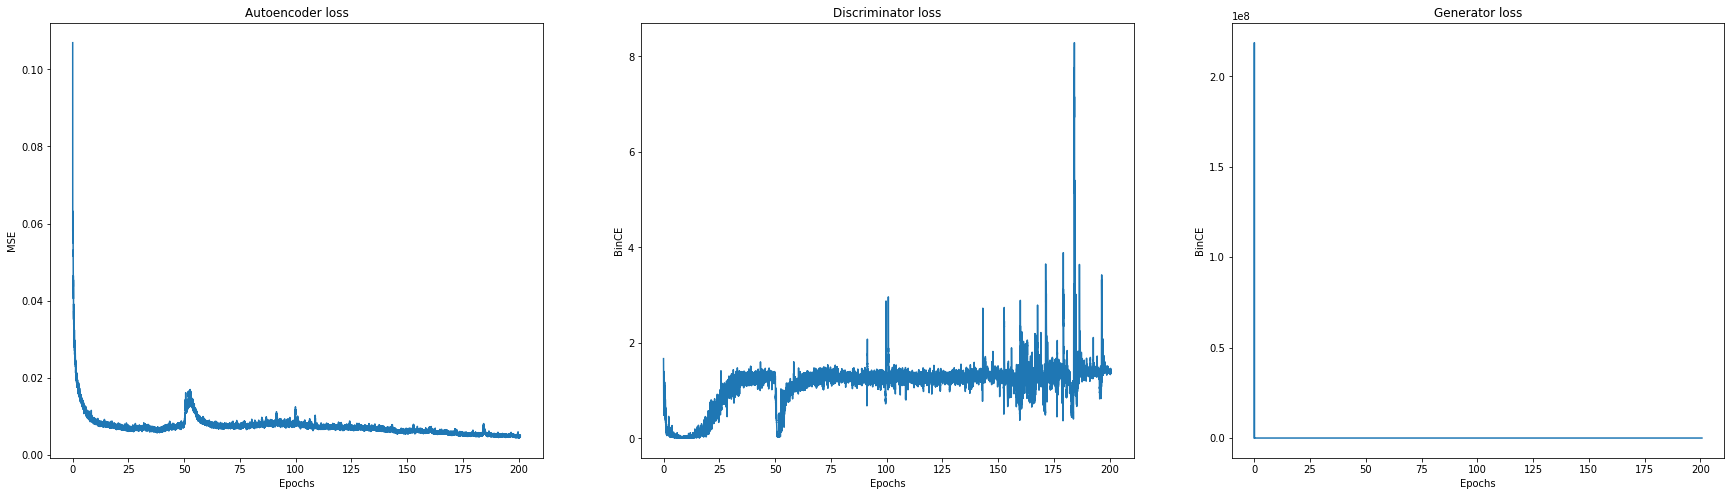

In [ ]:
steps_per_epoch = train_images.shape[0] / batch_size

F, ax = plt.subplots(1,3,figsize=(30,8))
ax[0].plot((np.arange(len(ae_loss_history))+1)/steps_per_epoch, ae_loss_history)
ax[0].set_title('Autoencoder loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('MSE')
ax[1].plot((np.arange(len(dc_loss_history))+1)/steps_per_epoch, dc_loss_history)
ax[1].set_title('Discriminator loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('BinCE')
ax[2].plot((np.arange(len(gen_loss_history))+1)/steps_per_epoch, gen_loss_history)
ax[2].set_title('Generator loss')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('BinCE')


In [ ]:
aae.encoder.save('Models/enc_model')
aae.decoder.save('Models/dec_model')
aae.discriminator.save('Models/dc_model')

2022-02-17 17:17:26.539700: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: Models/enc_model/assets


INFO:tensorflow:Assets written to: Models/dec_model/assets


INFO:tensorflow:Assets written to: Models/dc_model/assets


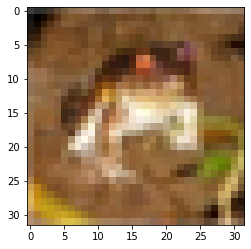

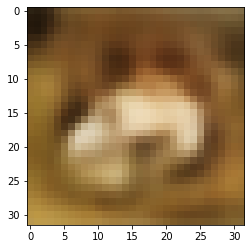

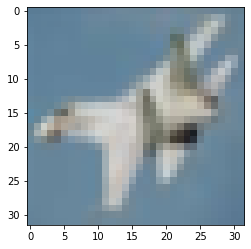

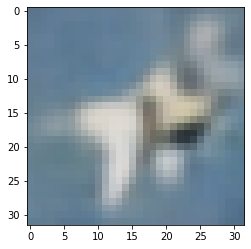

In [ ]:
image = train_images[0,:,:,:].reshape((1,32,32,3))
z = aae.encode_and_reparametrize(image)
image_recon = aae.decode(z, apply_sigmoid=True)
plt.figure()
plt.imshow(image[0,:,:,:])
plt.show()
plt.figure()
plt.imshow(image_recon[0,:,:,:])
plt.show()

image = test_images[10,:,:,:].reshape((1,32,32,3))
z = aae.encode_and_reparametrize(image)
image_recon = aae.decode(z, apply_sigmoid=True)
plt.figure()
plt.imshow(image[0,:,:,:])
plt.show()
plt.figure()
plt.imshow(image_recon[0,:,:,:])
plt.show()


In [ ]:
# Faccio il test error per batch perché sul mio PC la GPU va OOM
test_errors = []
for x_batch in test_dataset:
    test_err = aae.autoencoder_loss(x_batch)
    test_errors.append(test_err)
test_err = np.mean(test_errors)
print(test_err)

0.005347672


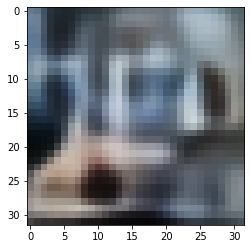

tf.Tensor([[-0.11771714]], shape=(1, 1), dtype=float32)


In [ ]:
z = np.random.randn(1,latent_dim)
image = aae.decode(z, apply_sigmoid=True).numpy()
image = image * 255.
image=image.astype('int16')
image.reshape((32,32,3))
plt.figure()
plt.imshow(image[0,:,:,:])
plt.show()
print(aae.discriminator(z))

In [ ]:
X = train_images[40503].reshape((1,32,32,3))
z = aae.encode_and_reparametrize(X)
print(z)
vote = aae.discriminator(z)
print(vote)

tf.Tensor(
[[ 0.7193408   0.05553487  0.12227565 -0.3648512  -1.3955014  -1.4137201
   0.6518663  -0.7605974   2.7514467  -0.02811721 -1.4607619   0.7896079
   0.28265807 -0.6153514   2.6821325  -0.5375256  -1.1314995   0.41192973
  -0.204583    1.0248005   0.9872948   1.8385996  -1.1307268   0.24542657
   2.3295102   0.5092304   2.4175408   1.7925744   0.83405495  0.22055013
  -1.2004929   0.17281178 -1.0907679   1.6161557   2.9473746  -1.2112014
  -0.9764377  -0.39036545 -1.3248469   0.40008235  1.1516716   1.0338537
  -0.6752238   0.9688325   0.3253951  -1.2258856   2.0675707  -0.13118912
  -1.9585363  -1.8839275  -1.3551112   1.4125195  -1.4071549  -1.8162637
  -0.04782546 -0.6969417   1.3754698  -0.21910188 -1.4290782  -0.9795167
  -1.0812621  -0.9477547  -0.30275428 -0.0815381  -0.50391644  1.9350313
  -0.18004382 -1.6797626  -0.24443883  0.08906607 -0.9776818   0.4603273
   0.30339664  0.1421525   2.27263    -0.07746702  1.4398313  -0.68306804
   1.1660594   2.279594   -2.012207

In [ ]:
import tensorflow as tf
a = 2
b = 3
c = 4
f_x = tf.constant([[1,1],[2,2],[3,3],[4,4],[5,5]])
print(f_x.shape)
T = tf.constant([[[1,1,1,1],[2,2,2,2],[3,3,3,3]],[[4,4,4,4],[5,5,5,5],[6,6,6,6]]])
print(T.shape)
M = tf.tensordot(f_x, T, axes=[[1],[0]])
print(M.shape)
diff = tf.expand_dims(M, 0) - tf.expand_dims(M,1)
print(diff.shape)
c = tf.norm(diff, ord=1, axis=3)
c = tf.cast(c, 'float')
c = tf.math.exp(-c)
print(c.shape)
o = tf.reduce_sum(c, axis=1)
print(o.shape)



(5, 2)
(2, 3, 4)
(5, 3, 4)
(5, 5, 3, 4)
(5, 5, 3)
(5, 3)
